# Viterbi Alignment

Viterbi Alignment and Trellis based Recognition 

In [1]:
####################################################################################
### RUNNING THIS CELL FIRST ##########
### will suppresses warnings on memory leaks, deprecation warnings and future warnings 
### It is brute force .  
### Best is not to run it when you want to debug code or new installations
import os, warnings 
os.environ["OMP_NUM_THREADS"] = '2'  
warnings.filterwarnings("ignore")
####################################################################################

In [2]:
#!pip install git+https://github.com/compi1234/pyspch.git
try:
    import pyspch
except ModuleNotFoundError:
    try:
        print(
        """
        To enable this notebook on platforms as Google Colab, 
        install the pyspch package and dependencies by running following code:

        !pip install git+https://github.com/compi1234/pyspch.git
        """
        )
    except ModuleNotFoundError:
        raise

In [3]:
%matplotlib inline
import io, os, sys
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import importlib
import urllib.request
import pickle
import gzip
import re
import torch
from sklearn import metrics as skmetrics 
from IPython.display import display, HTML, Audio

# print and plot
np.set_printoptions(precision=3)
cmap_jet2 = sns.mpl_palette("jet",60)[5:55]

# pyspch
import pyspch
import pyspch.core as Spch
import pyspch.display as Spd
import pyspch.stats.probdist as Densities
import pyspch.stats.libhmm as libhmm
from pyspch.stats import GMM, Prob
import pyspch.nn

# device
use_cuda_if_available = True
if use_cuda_if_available:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
else:
    device = "cpu"

from x_utils import plot_probs, get_test_file



In [4]:
#@title Auxiliary functions 
# dictionairy
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
def dict_from_module(module):
    context = {}
    for setting in dir(module):
        # you can write your filter here
        if not setting.startswith('_'):
            context[setting] = getattr(module, setting)

    return context

In [5]:

def select_phones_idx(phn_lists,phn_set,SORTED=False):
    ''' 
    creates a unique list of phones from a set of phone lists
    return the unique list AND their indices in a global phone set
    the order of appearance is preserved or sorted according to phn_set
    '''
    if not isinstance(phn_lists,tuple):
        phn_lists = ([],phn_lists)
    combined_list = []
    for phn_list in phn_lists:
        combined_list.extend(list(phn_list))
    select_list = []
    for phn in combined_list:
        if phn not in(select_list): select_list.append(phn) # list(np.unique(select_list))
    if SORTED:
        select_list = [ phn  for phn in phn_set if (phn in select_list) ] # sorted(select_list)
    select_idx = [phn_set.index(phn) for phn in select_list]
    return(select_list,select_idx)

In [6]:
def make_viterbi_graph(phn_seq,phn_set,STRICT=True):
    ''' 
    makes an HMM Graph to do a Viterbi Alignment on phn_seq
    it is implemented with a transition matrix with 0's and 1's
    STRICT
        True:   Enforce Viterbi 100%
        False:  Allow skips and begin/end in 2 adjacent states
    '''
    phn2idx = {lab: i for i, lab in enumerate(phn_set)}
    n_seq = len(phn_seq)
    obs_indx = np.zeros(n_seq,dtype='int')
    trans_mat = np.eye(n_seq,dtype='float32')
    init_mat = np.zeros(n_seq,dtype='float32')
    
    for i  in range(n_seq): 
        obs_indx[i] = phn2idx[phn_seq[i]]

    for i in range(n_seq-1):
        trans_mat[i,i+1] = 1.
        init_mat[0] = 1.0        

    if STRICT:
        end_states = np.array([n_seq-1])
    else:
        end_states = np.array([n_seq-2,n_seq-1])
        init_mat[1] = 1.0
        for i in range(n_seq-2):
            trans_mat[i,i+2]=1.
            
    return(obs_indx,trans_mat,init_mat,end_states)

In [7]:
def make_graph(phn_seq,phn_set,eps=0.0,skip=0.0):
    ''' 
    makes an HMM Graph to do recognition or alignment
    it is implemented with a transition matrix with mainly 0's and 1's
    - default is make a left-to-right graph of phn_seq
    - eps:  add ergodic arcs to all others with prob=eps
    - skip: add skip arcs with prob = skip
    STRICT
        True:   Enforce Viterbi 100%
        False:  Allow skips and begin/end in 2 adjacent states
    '''
    phn2idx = {lab: i for i, lab in enumerate(phn_set)}
    n_seq = len(phn_seq)
    obs_indx = np.zeros(n_seq,dtype='int')
    trans_mat = np.eye(n_seq,dtype='float32')
    init_mat = np.zeros(n_seq,dtype='float32')
    
    for i  in range(n_seq): 
        obs_indx[i] = phn2idx[phn_seq[i]]

    # set eps probabilities
    trans_mat = np.maximum(eps,trans_mat)
    init_mat = np.maximum(eps,init_mat)

    # add left-to-right arcs
    for i in range(n_seq-1):
        trans_mat[i,i+1] = 1.
        init_mat[0] = 1.0 
        if i+2 < n_seq:
            trans_mat[i,i+2] = np.maximum(eps,skip)
            
    return(obs_indx,trans_mat,init_mat,end_states)

## 1. Load the Observation Model

### Feature Extraction
MFCC26=  MFCC13 + Deltas + mean-variance normalization, (defined by feature_args).
### GMM models
**S41_D26_G64_FULL_1.pkl**  G64=64 Gaussians, S41= 41 classes/states, D26 = 26 dim features, (FrameRecog: 56%)

In [8]:
# task setup
root_url = 'https://homes.esat.kuleuven.be/~spchlab/data/'
timit_root = root_url + 'timit/'
#
# define feature extraction: MFCC13 + delta's + delta_delta's mean_variance_normalization
#
feature_args = {'spg': None,  # tells feature extraction to start from wav files
 'Deltas': 'delta_delta2',
 'Norm': 'meanvar',
 'sample_rate': 16000,
 'f_shift': 0.01,
 'f_length': 0.03,
 'preemp': 0.97,
 'window': 'hamm',
 'mode': 'dB',
 'n_mels': 24,
 'n_cep': 13}
#
# load an existing GMM model
#
gmm_root = timit_root+'models/gmm/'
gmm_model = Spch.load_data("S41_D26_G64_FULL_1.pkl",root=gmm_root)  # D26 = 26 dim features, G64 = 64 Gaussians, TIMIT = training database
gmm_nftrs = 26  # only use 26 features with gmms
phn_set= gmm_model.classes
phn2idx = {lab: i for i, lab in enumerate(phn_set)}

In [9]:
#
# read the DNN model
#
# = mfcc13, delta_delta2, meanvar, 11 frames, stride 2
model_path = 'models/default/mfcc13dd2mv/N5s2/' 
#model_path = 'models/default/mfcc13dd2mv/N0s1/' 

# read checkpoint 
model_fobj = pyspch.read_fobj(timit_root + model_path + 'model.pt')
checkpoint = pyspch.nn.read_checkpoint(model_fobj, device)

# unpack checkpoint (model, etc)
setup, lab2idx, model, criterion, optimizer, scheduler = checkpoint
# readout for one-hot encoding 
idx2lab = {v: k for k, v in lab2idx.items()}

setup = dotdict(setup)
model.to(device)

FFDNN(
  (net): Sequential(
    (0): Linear(in_features=429, out_features=1024, bias=True)
    (1): Sigmoid()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=1024, out_features=768, bias=True)
    (4): Sigmoid()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=768, out_features=512, bias=True)
    (7): Sigmoid()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=512, out_features=41, bias=True)
  )
)

In [10]:
# an sklearn style interface to our torch DNN models
class DNN_model():
    def __init__(self,priors=None,setup=None,model=None,device="cpu"):
        self.prob_style = "Prosteriors"
        self.class_prior_ = priors
        self.setup = setup
        self.model = model
        self.device = device
        
    def predict_proba(self,X):
        # X comes in as [n_samples, n_features], but splice_frames asssumes [n_features,n_samples]
        X_dnn = pyspch.sp.splice_frames(X.T,self.setup.sampler_args['N'], self.setup.sampler_args['stride'])
        print(X_dnn.shape)
        # posteriors 
        X_t = torch.tensor(X_dnn).T.float().to(self.device)
        yp_t = self.model(X_t) # log probs
        yp_t = torch.nn.Softmax(dim=1)(yp_t) # probs
        proba = yp_t.cpu().detach().numpy()
        return(proba)
dnn_model = DNN_model(setup=setup, model=model, device=device)    
dnn_nftrs = 39

## 2. Run Example File

The following cells take care of
1. loading test sample and segmentations
2. spg and feature computation
3. set some focus time to highlight one or a couple of words in a full sentence

The first cell will load our prototypical "friendly computers"; the second cell loads one of a few preselected TIMIT test files.
Just execute one of these cells

In [90]:
# loading a test file (non-TIMIT)
file_id =  'demo/friendly'
focus_times = np.array([0.5,1.04])
focus_times = np.array([0.5,0.8])
type = None

In [ ]:
# loading a test file (non-TIMIT)
file_id =  'misc/bad_bead_booed'
focus_times = np.array([1.5,2.1])
type = None

In [ ]:
# loading a test file (non-TIMIT)
file_id =  'digits/5752'
focus_times = np.array([0.25,1.05])
type = None

In [ ]:
# loading a TIMIT test file
# choose an example from 0 .. 4 
file_id = 4
timit_focus_times = [ [2.10,3.07], [.12,.88], [.05,.51], [0.,.85], [1.26,2.65], [0.,1], [0.,1], [0.,1.]]
focus_times = np.array(timit_focus_times[file_id])
type = "TIMIT"

friendly computers      t0    t1        seg
0  0.01  0.44   friendly
1  0.49  1.04  computers


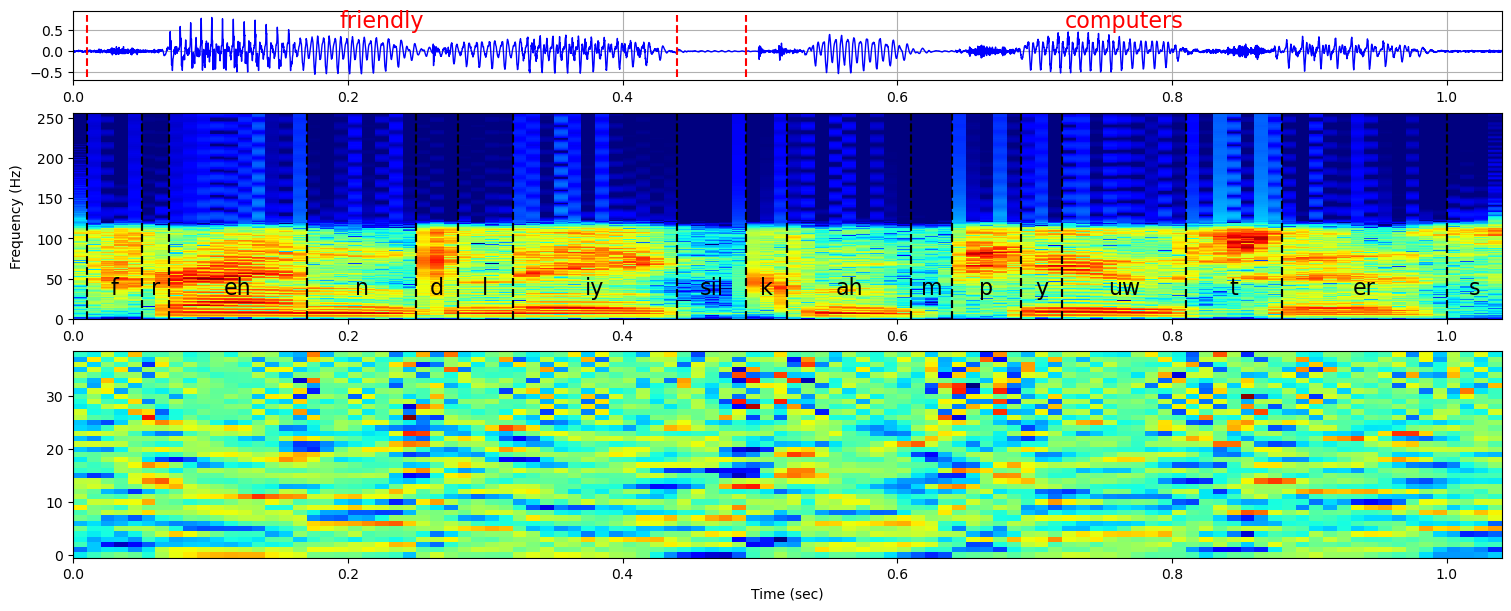

In [12]:
# load all the data
wavdata, sr, spgdata, ftrs, txt, seg_wrd, seg_phn = get_test_file(file_id,feature_args=feature_args,type=type)
print(txt,seg_wrd)
# select a time segment to focus on and find corresponding phones / transcription
labels = pyspch.seg2lbls(seg_phn, n_frames=ftrs.shape[1],pad_lbl='sil')
shift=feature_args['f_shift']
#  SHOW THE EXAMPLE: waveform, spectrogram, features, reference transcription and segmentation
##############################################################################################
fig = pyspch.display.PlotSpgFtrs(wavdata=wavdata, spgdata=spgdata,dy=1,
                                  sample_rate=sr, figsize=(15,6), img_ftrs=[ftrs])
fig.add_seg_plot(seg_phn, iax=1, ypos=.15, color='k') 
fig.add_seg_plot(seg_wrd, iax=0, ypos=.9, color='r') # seg
display(fig)
display(Audio(data=wavdata,rate=sr))

### Frame Probabilities

In [91]:
model = gmm_model
nftrs = 26
#model = dnn_model
#nftrs = 39
X=ftrs[:nftrs,:].T
y_frame_prob = model.predict_proba(X)

### Frame Recognition

In [92]:
# compute frame posterior probabilities and do frame by frame recognition, compute the frame error rate in the sentence
##########################################################################
# evaluate frame based recognition wrt. manual segmentations
y_frame_idx = np.argmax(y_frame_prob, axis=1)
y_frame_lab = [phn_set[i] for i in y_frame_idx]
# alternative
# y_frame_lab = obs_model.predict(X=features.T)
t = np.arange(len(y_frame_lab))*shift+0.5*shift
y_frame_ldf = pd.DataFrame({'t':t,'lbl':y_frame_lab})
y_frame_seg = pyspch.lbls2seg(y_frame_lab)
n_corr = np.sum([y_frame_lab[i] == labels[i] for i in range(len(labels))])
print("Frame Recognition Rate (for full utterance): %.2f %%" % (100.*n_corr/len(labels)))
#

Frame Recognition Rate (for full utterance): 21.15 %


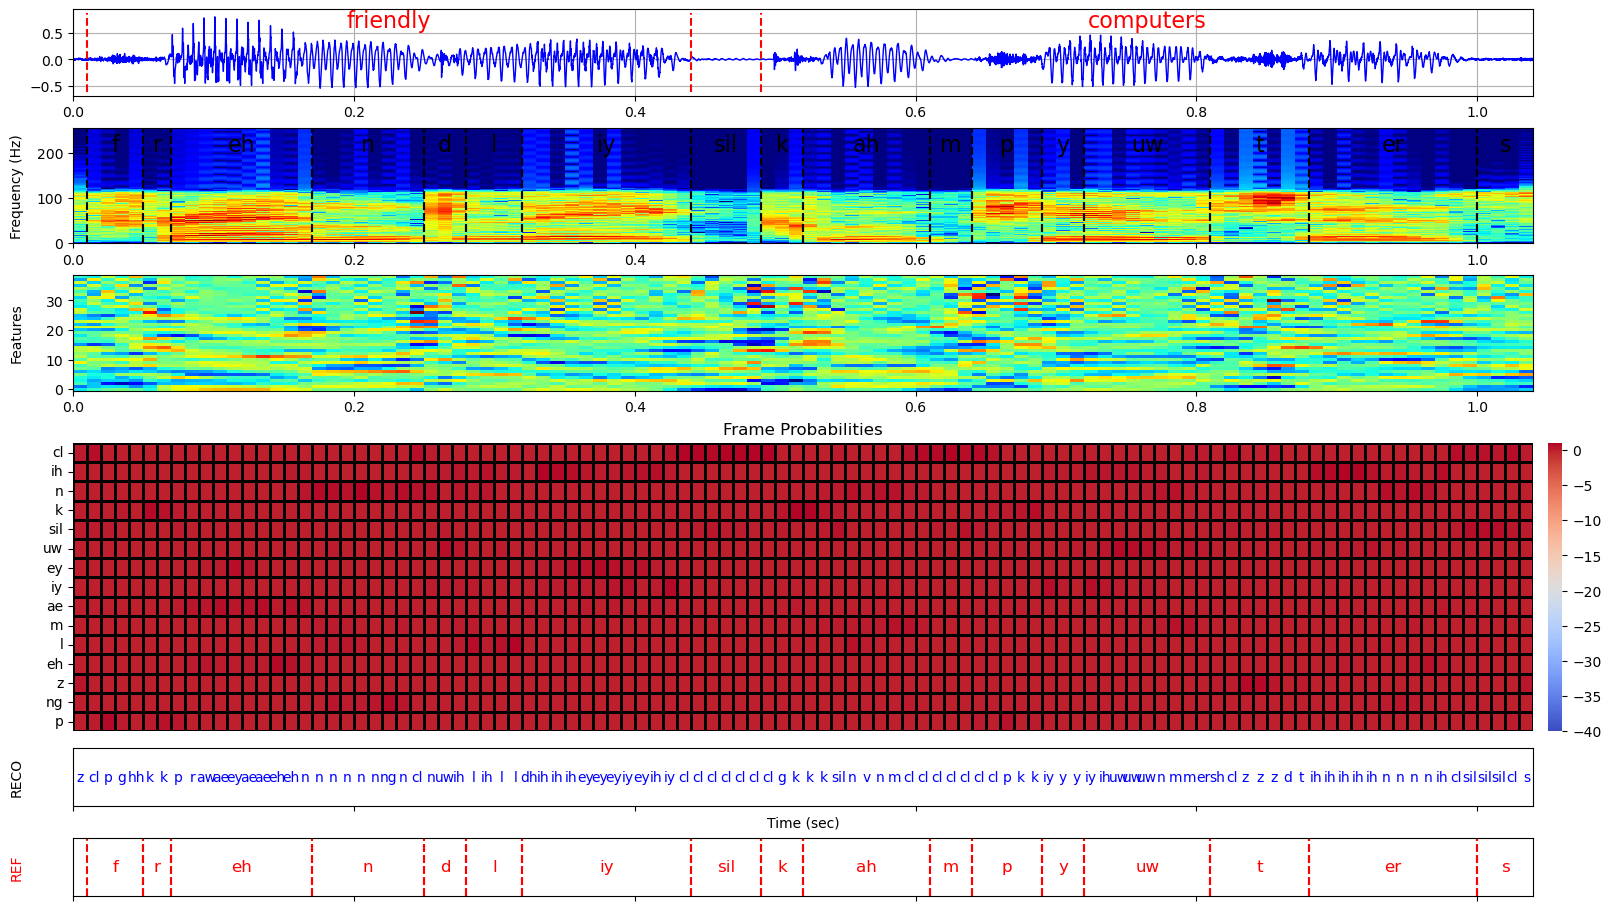

In [93]:
top_k = 15
indx_sel = np.argsort(np.sum(y_frame_prob,axis=0))[::-1][0:top_k]
phn_sel = [phn_set[i] for i in indx_sel]
fig = pyspch.display.PlotSpgFtrs(wavdata=wavdata, spgdata=spgdata,dy=1,row_heights=[1.5,2,2,5,1,1],
            sample_rate=sr, figsize=(16,9), img_ftrs=[ftrs,None,None],img_labels=['Features',None,None])
(iax_wav, iax_spg, iax_ftr, iax_prob, iax_frame, iax_ref) = (0,1,2,3,4,5)
fig.add_seg_plot(seg_phn, iax=iax_spg, ypos=.85, color='k') # seg
fig.add_seg_plot(seg_wrd, iax=iax_wav, ypos=.9, Lines=True, color='r')

#plot_probs(prob_dnn_sel, phn_sel,fig=fig, iax=0, x0=frames[0]*.01, style="line", title="DNN Posterior Probs") # probs
#plot_probs(y_frame_prob[frame_sel,indx_sel], phn_sel,fig=fig, iax=3, x0=frames[0]*shift, style="line", title="GMM Posterior Probs")
plot_probs(y_frame_prob[:,indx_sel], phn_sel,fig=fig, cmap='coolwarm',iax=iax_prob, style="img", title="Frame Probabilities")

fig.add_seg_plot(y_frame_ldf,iax=iax_frame,ypos=.5,color='#00F',size=10)
fig.add_seg_plot(seg_phn,iax=iax_ref,ypos=.5,color='r',size=12)
fig.axes[iax_frame].set_ylabel('RECO')
fig.axes[iax_ref].set_ylabel('REF',color='r')
display(fig)

### Viterbi Alignment

In [94]:
transcript = seg_phn['seg'].tolist()
obs_indx, trans_mat,init_mat,end_states = make_viterbi_graph(transcript,phn_set,STRICT=True)
hmm2 = libhmm.HMM(prob_style="lin",obs_indx=obs_indx,obs_model=model,states=transcript,transmat=trans_mat,initmat=init_mat,end_states=end_states)
# setting to log-probabilities gives a better impression of relevant ranges
hmm2.set_probstyle('log')
trellis2=libhmm.Trellis(hmm2,Normalize=True)
trellis2.viterbi_pass(X)
# recognize from the trellis
y_vit_lbl = hmm2.states[trellis2.backtrace()]
y_vit_ldf = pd.DataFrame({'t':t,'lbl':y_vit_lbl})
y_vit_seg = Spch.lbls2seg(y_vit_lbl)
n_corr = np.sum([y_vit_lbl[i] == labels[i] for i in range(len(y_vit_lbl))])
print("Agreement with manual alignment: %.2f %%" % (100.*n_corr/len(y_vit_lbl)))

Agreement with manual alignment: 78.85 %


In [113]:
transcript = seg_phn['seg'].tolist()
skip=.0
eps=0.
obs_indx, trans_mat,init_mat,end_states = make_graph(transcript,phn_set,eps=eps,skip=skip)
#
# for the HMM we use likelihoods instead of posteriors
#
obs_model = Prob(style="Posteriors",priors=gmm_model.class_prior_)
X_p = obs_model.predict_ftr_prob(y_frame_prob)
hmm2 = libhmm.HMM(prob_style="lin",obs_indx=obs_indx,obs_model=obs_model,states=transcript,transmat=trans_mat,initmat=init_mat,end_states=end_states)
# setting to log-probabilities gives a better impression of relevant ranges
hmm2.set_probstyle('log')
#obs_probs_raw = obs_model.predict_log_prob(X)
trellis2=libhmm.Trellis(hmm2,Normalize=True)
trellis2.viterbi_pass(X_p)
# recognize from the trellis
y_vit_lbl = hmm2.states[trellis2.backtrace()]
y_vit_ldf = pd.DataFrame({'t':t,'lbl':y_vit_lbl})
y_vit_seg = Spch.lbls2seg(y_vit_lbl)
n_corr = np.sum([y_vit_lbl[i] == labels[i] for i in range(len(y_vit_lbl))])
print("Agreement with manual alignment: %.2f %%" % (100.*n_corr/len(y_vit_lbl)))

Agreement with manual alignment: 76.92 %


### Plot Selected Segments and Phones

In [114]:
focus_times = np.array([0.5, 1.04])
frames= (focus_times/shift).astype('int')
samples = (focus_times*sr).astype('int')
sample_sel = slice(samples[0],samples[1])
frame_sel = slice(frames[0],frames[1])
seg_sel = seg_phn[(seg_phn['t0']<frames[1]*shift) & (seg_phn['t1']>frames[0]*shift)]
state_sel = np.array(seg_sel.index.tolist())
label_sel = labels[frame_sel]

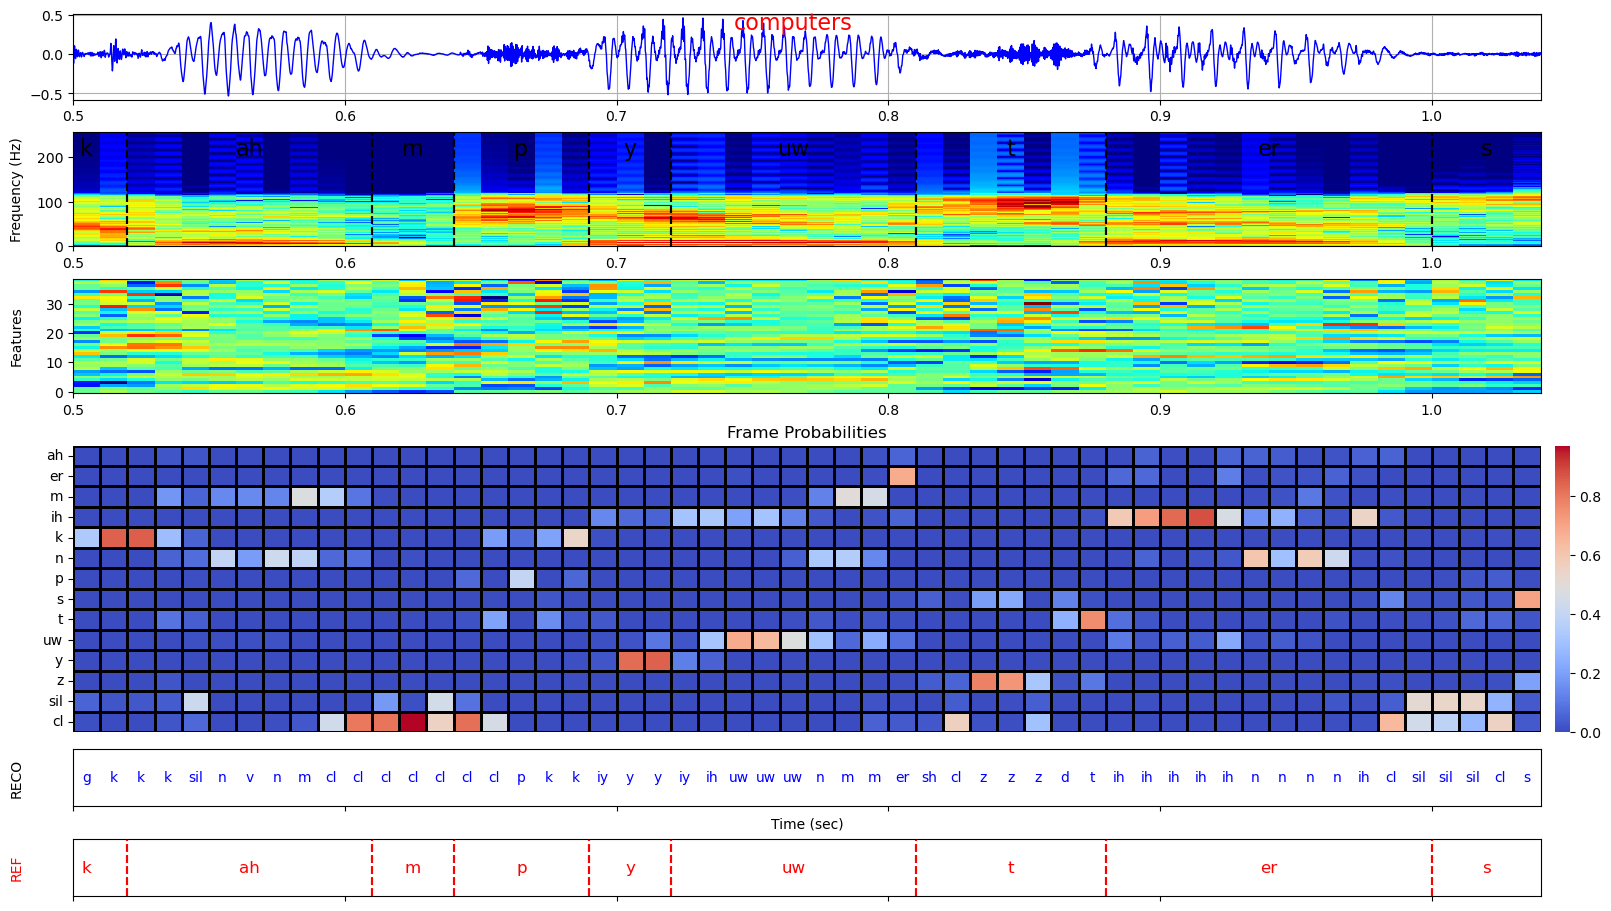

Frame Recognition Rate: 9/54 (16.67%)


In [115]:
# make a selection of phones to plot
# include the most likely outputs and the phones in the transcriptions
top_k = 10
indx_sel = np.argsort(np.sum(y_frame_prob[frame_sel,:],axis=0))[::-1][0:top_k]
phn_sel = [phn_set[i] for i in indx_sel]
phn_sel, indx_sel = select_phones_idx((seg_sel['seg'],phn_sel,['sil']),phn_set,SORTED=True)

# plot frame posterior probs and phones for a short segment and a selection of phones
######################################################################################
fig = pyspch.display.PlotSpgFtrs(wavdata=wavdata, spgdata=spgdata,dy=1,row_heights=[1.5,2,2,5,1,1],
            frames=frames, sample_rate=sr, figsize=(16,9), img_ftrs=[ftrs,None,None],img_labels=['Features',None,None])
(iax_wav, iax_spg, iax_ftr, iax_prob, iax_frame, iax_ref) = (0,1,2,3,4,5)
fig.add_seg_plot(seg_phn, iax=iax_spg, ypos=.85, color='k') # seg
fig.add_seg_plot(seg_wrd, iax=iax_wav, ypos=.9, Lines=True, color='r')

plot_probs(y_frame_prob[frame_sel,indx_sel], phn_sel,fig=fig, cmap='coolwarm',iax=iax_prob, vmin=None, x0=frames[0]*shift, style="img", title="Frame Probabilities")
fig.add_seg_plot(y_frame_ldf,iax=iax_frame,ypos=.5,color='#00F',size=10)
fig.add_seg_plot(seg_phn,iax=iax_ref,ypos=.5,color='r',size=12)
fig.axes[iax_frame].set_ylabel('RECO')
fig.axes[iax_ref].set_ylabel('REF',color='r')
display(fig)
n_corr = np.sum([y_frame_lab[i] == labels[i] for i in range(frames[0],frames[1])])
n_frames = (frames[1]-frames[0])
print("Frame Recognition Rate: %d/%d (%.2f%%)" % (n_corr,n_frames,100.*n_corr/n_frames))

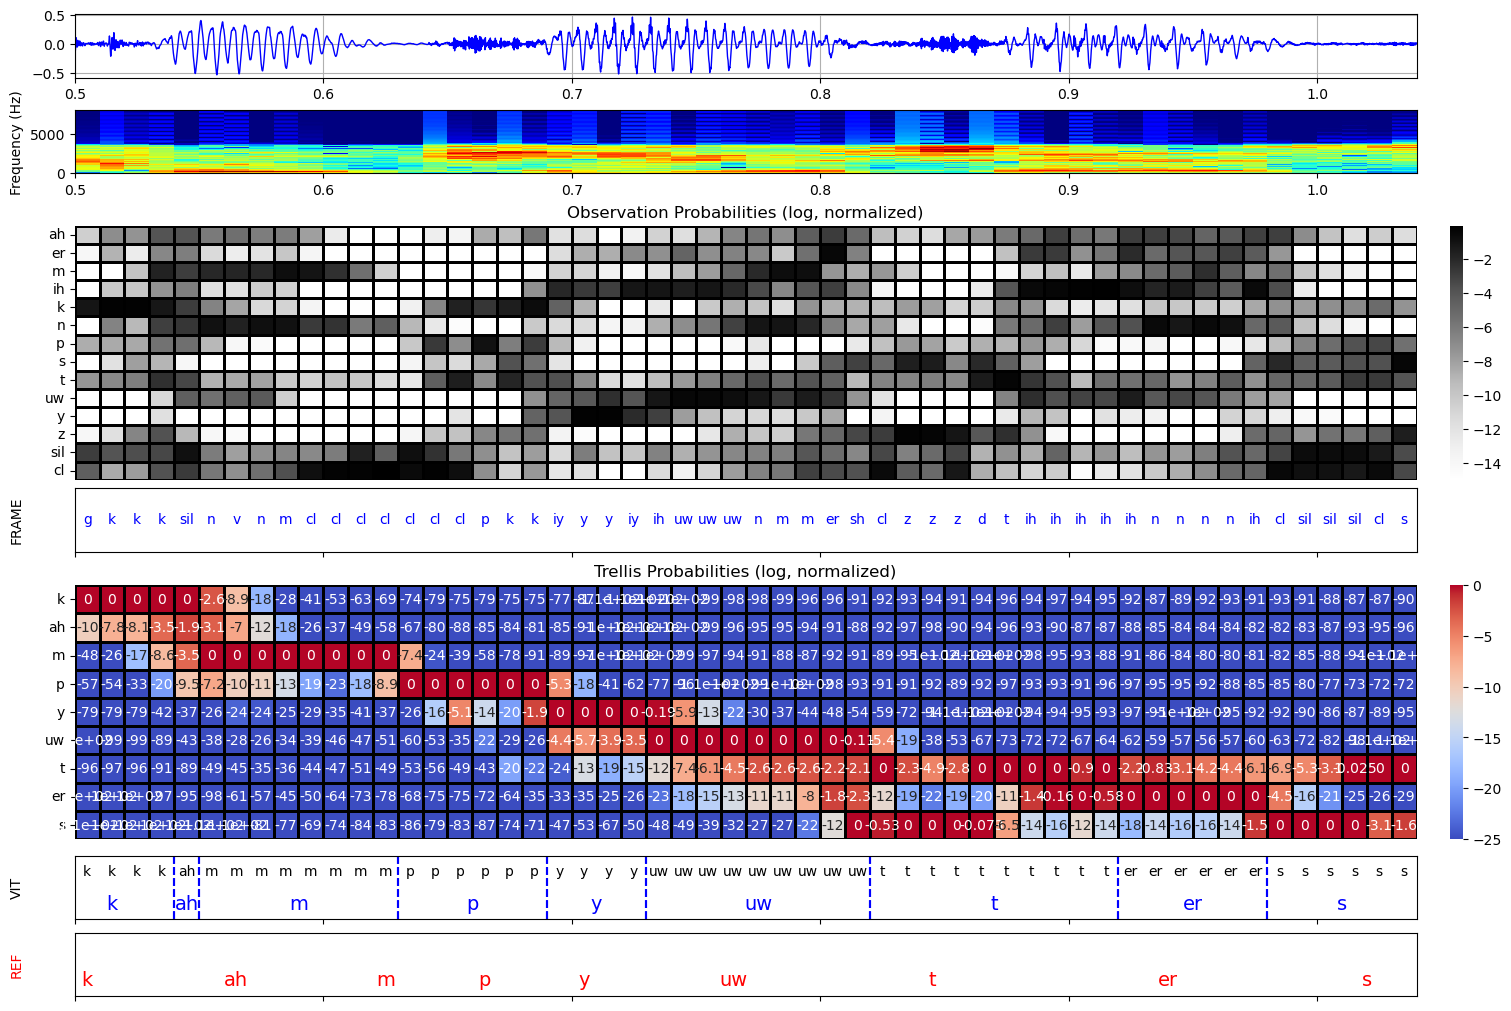

In [121]:
transcript_sel = np.array(transcript)[state_sel]


fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spgdata,frames=frames,sample_rate=sr,figsize=(15,10),row_heights=[1,1,4,1,4,1,1],
                  img_ftrs=[None,None,None])
(iax_wav, iax_spg, iax_prob, iax_frame, iax_trel, iax_vit, iax_ref) = (0,1,2,3,4,5,6)
# plot normalized observation probabilities
obs_probs = np.log(y_frame_prob) #obs_probs_raw-np.max(obs_probs_raw,axis=1,keepdims=True)
trel_probs = trellis2.probs
plot_probs(obs_probs[frame_sel,indx_sel],fig=fig,iax=iax_prob,labels=phn_sel,cmap="Greys",style="img",vmin=-15.,title="Observation Probabilities (log, normalized)")
plot_probs(trel_probs[frame_sel,state_sel],fig=fig,cmap='coolwarm',labels=transcript_sel,iax=iax_trel,style="img",vmin=-25.,title="Trellis Probabilities (log, normalized)",annot=True)
#fig.add_seg_plot(seg_wrd,iax=0,ypos=0.8,color='k')

#fig.add_seg_plot(y_vit_seg,iax=4,ypos=0.5,color='b',title='Viterbi Alignment')

fig.add_seg_plot(y_frame_ldf,iax=iax_frame,ypos=.5,color='#00F',size=10)
fig.add_seg_plot(y_vit_ldf,iax=iax_vit,ypos=.75,color='#000',size=10)
fig.add_seg_plot(y_vit_seg,iax=iax_vit,ypos=.25,color='#00F',size=14)
fig.add_seg_plot(seg_phn,iax=iax_ref,ypos=.25,color='r',size=14,Lines=False)
fig.axes[iax_frame].set_ylabel('FRAME')
fig.axes[iax_vit].set_ylabel('VIT')
fig.axes[iax_ref].set_ylabel('REF',color='r')
fig.axes[iax_frame].set_xlabel("")
#fig.add_seg_plot(seg_phn,iax=iax_ref,ypos=0.2,color='b',title='Reference Alignment')
display(fig)


In [106]:
y_vit_seg

,t0,t1,seg
0,0.00,0.07,f
1,0.07,0.09,r
2,0.09,0.16,eh
3,0.16,0.25,n
4,0.25,0.28,d
5,0.28,0.33,l
6,0.33,0.44,iy
7,0.44,0.49,sil
8,0.49,0.54,k
9,0.54,0.55,ah


In [82]:
xseg = y_vit_seg.iloc[0][0:2].tolist()
xseg

[0.0, 0.07]

In [83]:
frames[0]

50

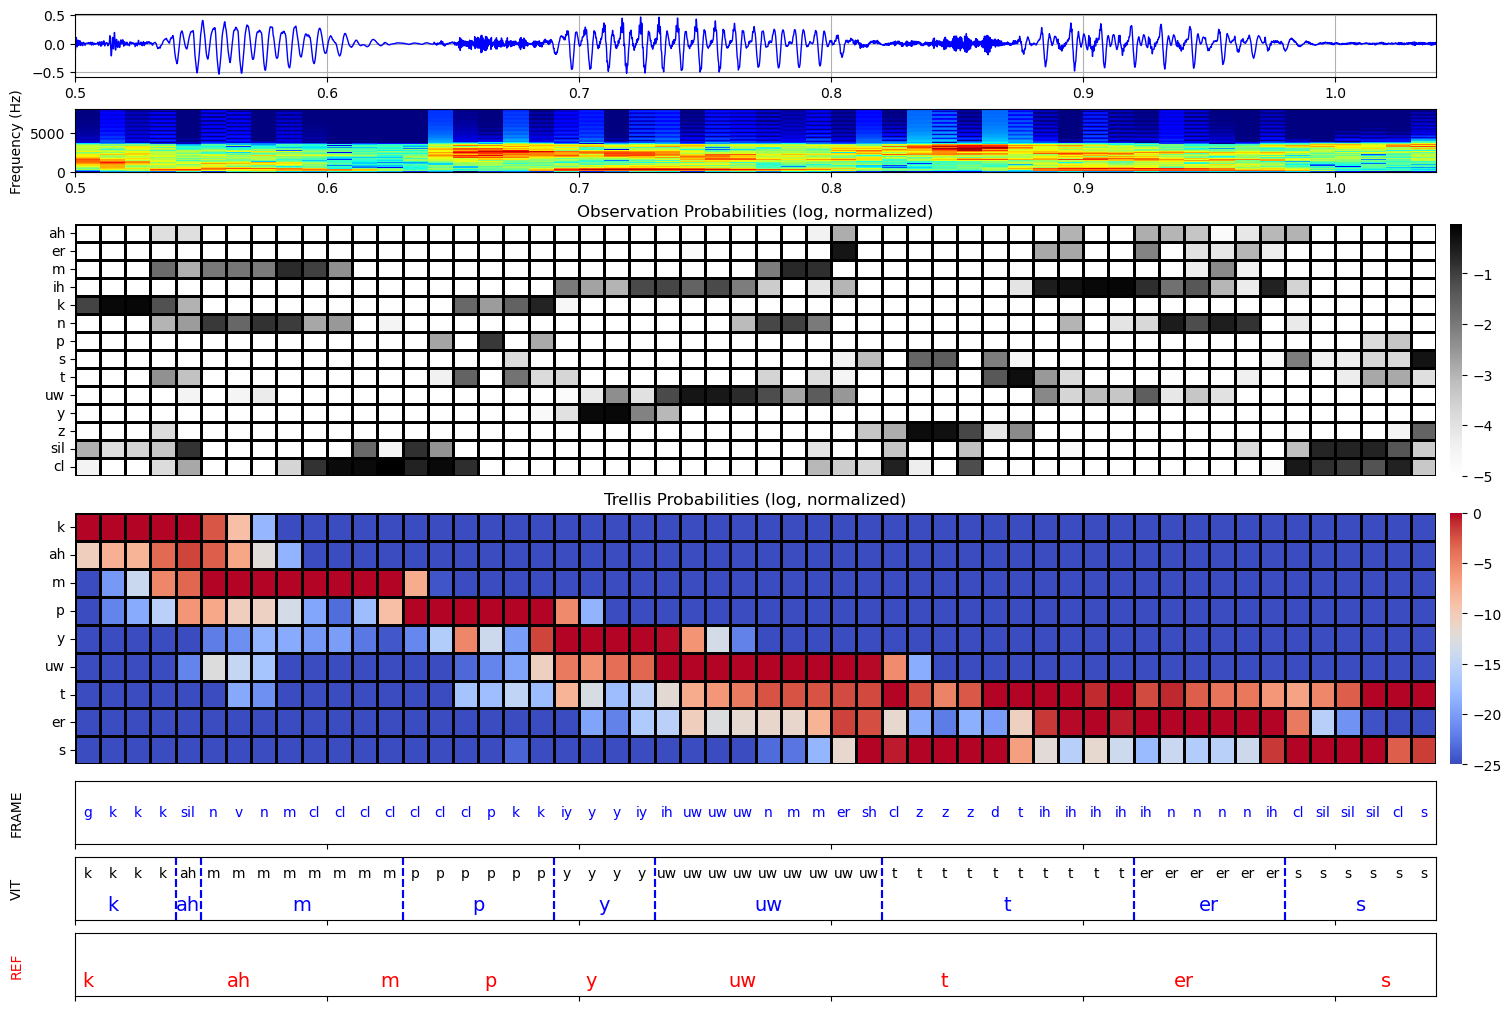

In [84]:
#fig.add_seg_plot(y_vit_seg,iax=iax_trel,Labels=False)
#xseg=[10,21]
for i in range(y_vit_seg.shape[0]):
    xseg = np.array(y_vit_seg.iloc[i][0:2].tolist())*100.
    if xseg[0] >= frames[0]:
        fig.axes[iax_trel].vlines(xseg-frames[0],i,i+1,colors='white')
#add_vlines(xseg,iax=iax_trel,color='#F00',linestyle='dashed')
display(fig)

In [ ]:
pd.set_option('display.float_format', '{:.2f}'.format)
i1 = 52
i2 = 64
dfo1 = pd.DataFrame(obs_probs[i1:i2,indx_sel].T,index=phn_sel,columns=np.arange(i1,i2))
dft1 = pd.DataFrame(trel_probs[i1:i2,state_sel].T,index=transcript_sel,columns=np.arange(i1,i2))
dfo2 = pd.DataFrame(obs_probs[i1:i2,:].T,index=phn_set,columns=np.arange(i1,i2))
dft2 = pd.DataFrame(trel_probs[i1:i2,:].T,index=transcript,columns=np.arange(i1,i2))

In [ ]:
display(dfo1, dft1)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(16,16))

kwargs = {"cmap":"coolwarm","fmt":".2f","linewidths":1,"linecolor":'k',"annot":True,"annot_kws":{"fontsize":8},'cbar':False,'square':False}
sns.heatmap(dfo2,ax=ax[0],**kwargs)
sns.heatmap(dft2,ax=ax[1],**kwargs)
#cmap="coolwarm",fmt=".2f",linewidths=1,linecolor='k',annot=True) #, ax=ax, yticklabels=labels, cmap=cmap,vmin=vmin,,cbar_kws={'pad':0.0})
for axx in ax: axx.set_yticklabels(axx.get_yticklabels(), rotation=0)
#ax.set_xticks([])

In [ ]:
dft1

In [ ]:
phn_sel

In [ ]:
obs_probs.shape,trel_probs[-30:,-5:]

In [ ]:
ph2indx